# NOTEBOOOK DE CREATION DES ORIGINE DESTINATION LAPI

In [2]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os, math
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. import des données, traitement de mise en forme
### 1.1 Import

In [3]:
%%time 
#df_3semaines=pd.read_json(r'E:\Boulot\lapi\df_3semaines.json', orient='index')
df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')
df_3semaines=df_3semaines.set_index('created').sort_index()

Wall time: 1min 53s


## 1.2 Traitement des doublons

In [ ]:
#trouver les doublons
doublons=df_3semaines.reset_index()
doublons.loc[doublons.duplicated(['created','immat'],keep=False)]
#supprimer les doublons
#df_3semaines=df_3semaines.drop_duplicates(['created','immat'])

In [27]:
%%time 
#verifier si des passages sont trop proches

#fonction de test d'ecart entre les passages
def ecart_passage(liste_passage, liste_camera,state) : 
    for i in range(len(liste_passage)-1):
        if (pd.to_datetime(liste_passage[i+1])-pd.to_datetime(liste_passage[i])<pd.Timedelta('00:05:00') and 
            pd.to_datetime(liste_passage[i])!=pd.to_datetime(liste_passage[i+1]) and state!='!!') : #on trouve l'enchainement en moins de 5minutes, sans prendre les doublons
            return True
    else : return False
def conserver_state(liste_state):
    if '!!' in liste_state : 
        return '!!'
    else : return liste_state[0]
def test_unicite_type(liste_l, mode='unique'):
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
def liste_passage(liste_cam, liste_created) : 
    liste_passage=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_passage.append(liste_cam[i])
            liste_passage.append(liste_cam[i+1])
    return liste_passage
def liste_created(liste_cam, liste_created) : 
    liste_created_fin=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_created_fin.append(liste_created[i])
            liste_created_fin.append(liste_created[i+1])
    return liste_created_fin

#on grouep les données et modifie les colonnes
groupe=(df_3semaines.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x),'l': lambda x : test_unicite_type(list(x),'1/2'), 
                                                              'created':lambda x: tuple(x),'state':lambda x : conserver_state(list(x)) }))
#on isole les pl
groupe_pl=groupe.loc[groupe['l']==1].copy()
#on ajoute une colonne drapeau pour localiser le pb
groupe_pl['erreur_tps_passage']=groupe_pl.apply(lambda x :  ecart_passage(x['created'], x['camera_id'], x['state']),axis=1)
#et on extrait unqiement les passages problemetaique
groupe_pl_rappro=groupe_pl[groupe_pl['erreur_tps_passage']].copy()
groupe_pl_rappro['liste_passag_faux']=groupe_pl_rappro.apply(lambda x : liste_passage(x['camera_id'],x['created']),axis=1)
groupe_pl_rappro['liste_created_faux']=groupe_pl_rappro.apply(lambda x : liste_created(x['camera_id'],x['created']),axis=1)
#obteniur le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']]

#!!!!!!! ATTENTION : PAS DE TRAITEMENTS EFFECTUES POUR CES ERREURS POUR LE MOMENT !
#propositions : supprimer 1 des 2 occurences pour les docblons
#supprmer les plques mal lues.


In [27]:
#redresser la valeur de l
df_journee.loc[df_journee['camera_id']==15,'l']=1

# 2. Création des trajets
## 2.1 Liste des trajets
>Liste créée à la main au départ, puis sauvegardée dans un fichier json.<br> on ajoute ensuite les données de longueur et tempsdeparcours théorique, sur la base d'un vitesse pl motyenne de 80 km/h pour vavoir un peu de marge

In [4]:
liste_complete_trajet=pd.read_json(r'E:\Boulot\lapi\trajets_possibles.json', orient='index')
liste_complete_trajet['cameras']=liste_complete_trajet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_complete_trajet['tps_parcours_theoriq']=liste_complete_trajet.apply(lambda x : pd.Timedelta(milliseconds=x['tps_parcours_theoriq']),axis=1)
liste_complete_trajet.sort_values('nb_cams', ascending=False, inplace=True)

In [5]:
liste_complete_trajet

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,11,15,"(15, 19, 4, 5, 11)",A10,120.325213,5,A63-A10,A63,01:30:14.634000
1,11,15,"(15, 19, 1, 5, 11)",A10,125.202188,5,A63-A10,A63,01:33:54.098000
13,13,12,"(12, 6, 3, 18, 13)",A63,105.139253,5,A10-A63,A10,01:18:51.266000
12,13,12,"(12, 6, 2, 18, 13)",A63,108.707013,5,A10-A63,A10,01:21:31.815000
56,7,15,"(15, 19, 4, 7)",A89,90.709158,4,A63-A89,A63,01:08:01.912000
36,11,10,"(10, 4, 5, 11)",A10,64.969553,4,A62-A10,A62,00:48:43.629000
31,13,6,"(6, 3, 18, 13)",A63,85.355597,4,N10-A63,N10,01:04:01.001000
25,5,15,"(15, 19, 1, 5)",N10,89.925738,4,A63-N10,A63,01:07:26.658000
24,5,15,"(15, 19, 4, 5)",N10,85.048763,4,A63-N10,A63,01:03:47.194000
30,13,6,"(6, 2, 18, 13)",A63,88.923357,4,N10-A63,N10,01:06:41.551000


## 2.2 Constitution de la base des trajets de transit
>obtention de 3 dataframes : 
- contenant les trajets de transit
- contenant les passages de transit
- contenant les temps maxi autorisés pour etre considéré comme transit, et le type detems maxi (cluster ou reglementaire)

### 2.2.1. Base : trajets qui collent avec ceux prévus dans la liste des trajets

In [6]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-29 00:00:00',7,df_3semaines)

date : 2019-01-29 00:00:00 debut_traitement : 2019-05-02 20:38:28.400546
date : 2019-01-29 01:00:00 debut_traitement : 2019-05-02 20:38:29.431788
date : 2019-01-29 02:00:00 debut_traitement : 2019-05-02 20:38:30.140892
date : 2019-01-29 03:00:00 debut_traitement : 2019-05-02 20:38:30.964729
date : 2019-01-29 04:00:00 debut_traitement : 2019-05-02 20:38:31.910167
date : 2019-01-29 05:00:00 debut_traitement : 2019-05-02 20:38:33.158862
date : 2019-01-29 06:00:00 debut_traitement : 2019-05-02 20:38:35.044826
date : 2019-01-29 07:00:00 debut_traitement : 2019-05-02 20:38:39.705371
date : 2019-01-29 08:00:00 debut_traitement : 2019-05-02 20:38:45.605570
date : 2019-01-29 09:00:00 debut_traitement : 2019-05-02 20:38:53.804690
date : 2019-01-29 10:00:00 debut_traitement : 2019-05-02 20:38:58.939966
date : 2019-01-29 11:00:00 debut_traitement : 2019-05-02 20:39:03.898719
date : 2019-01-29 12:00:00 debut_traitement : 2019-05-02 20:39:08.523356
date : 2019-01-29 13:00:00 debut_traitement : 2019-

*important : controle si doublons entre trajets*.<br> pourrait faire l'objet d'une fonction supp

In [ ]:
for destination in ['N10','A10','A63','A660', 'A89', 'A62'] : 
    print (t.verif_doublons_trajet(dico_od, destination))

### 2.2.2. Filtrer les trajets selon un temps de parcours
> Lorsque l'on utilise transit_temps_complet, le dico de stemps max est crée (On regroupe les trajets par Cluster, on utilise une df des parametres à utiliser pour les cluster basée sur des observations perso et un travail à la main). <br> En premier lieu on corrige ce dico des temps max en prenant un moyenne des temps max de type Cluster lorsque ceux ci encadre un temps max de type '85_percentile). <br> Là, on met un attribut drapeau pour identifier les trajets de transit.<br> la fonction graph_transit_filtre_multiple permet de visualiser les trajets de transit sur plusieurs jours, pour une o_d

In [7]:
#pour info : parametres cluster
param_cluster=pd.read_json(r'E:\Boulot\lapi\param_cluster.json', orient='index')
param_cluster

,delai,nb_pt_min,temps_etudie,trajet
0,600,4,15,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
1,1200,4,60,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
2,800,3,15,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
3,1000,4,60,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"


In [8]:
#dico des temps max issus du lapi corrigé avec moyenne cluster
dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

In [291]:
dixco_tpsmax_corrige.loc[(dixco_tpsmax_corrige['o_d']=='N10-A63') & (dixco_tpsmax_corrige['date']>=pd.to_datetime('2019-01-31'))]

,date,temps,type,o_d,period
1688,2019-01-31 00:00:00,01:51:09,Cluster,N10-A63,2019-01-31 00:00
1698,2019-01-31 01:00:00,01:38:28,Cluster,N10-A63,2019-01-31 01:00
1714,2019-01-31 02:00:00,01:43:54,Cluster,N10-A63,2019-01-31 02:00
1727,2019-01-31 03:00:00,01:36:43,Cluster,N10-A63,2019-01-31 03:00
1745,2019-01-31 04:00:00,01:51:47,Cluster,N10-A63,2019-01-31 04:00
1768,2019-01-31 05:00:00,01:45:58,Cluster,N10-A63,2019-01-31 05:00
1785,2019-01-31 06:00:00,02:36:56,Cluster,N10-A63,2019-01-31 06:00
1807,2019-01-31 06:15:00,02:46:50,moyenne Cluster,N10-A63,2019-01-31 06:15
1824,2019-01-31 06:30:00,02:56:44,Cluster,N10-A63,2019-01-31 06:30
1843,2019-01-31 06:45:00,02:46:55.500000,moyenne Cluster,N10-A63,2019-01-31 06:45


In [10]:
# df complete avec l'atribut filtre
df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,liste_complete_trajet, 15)

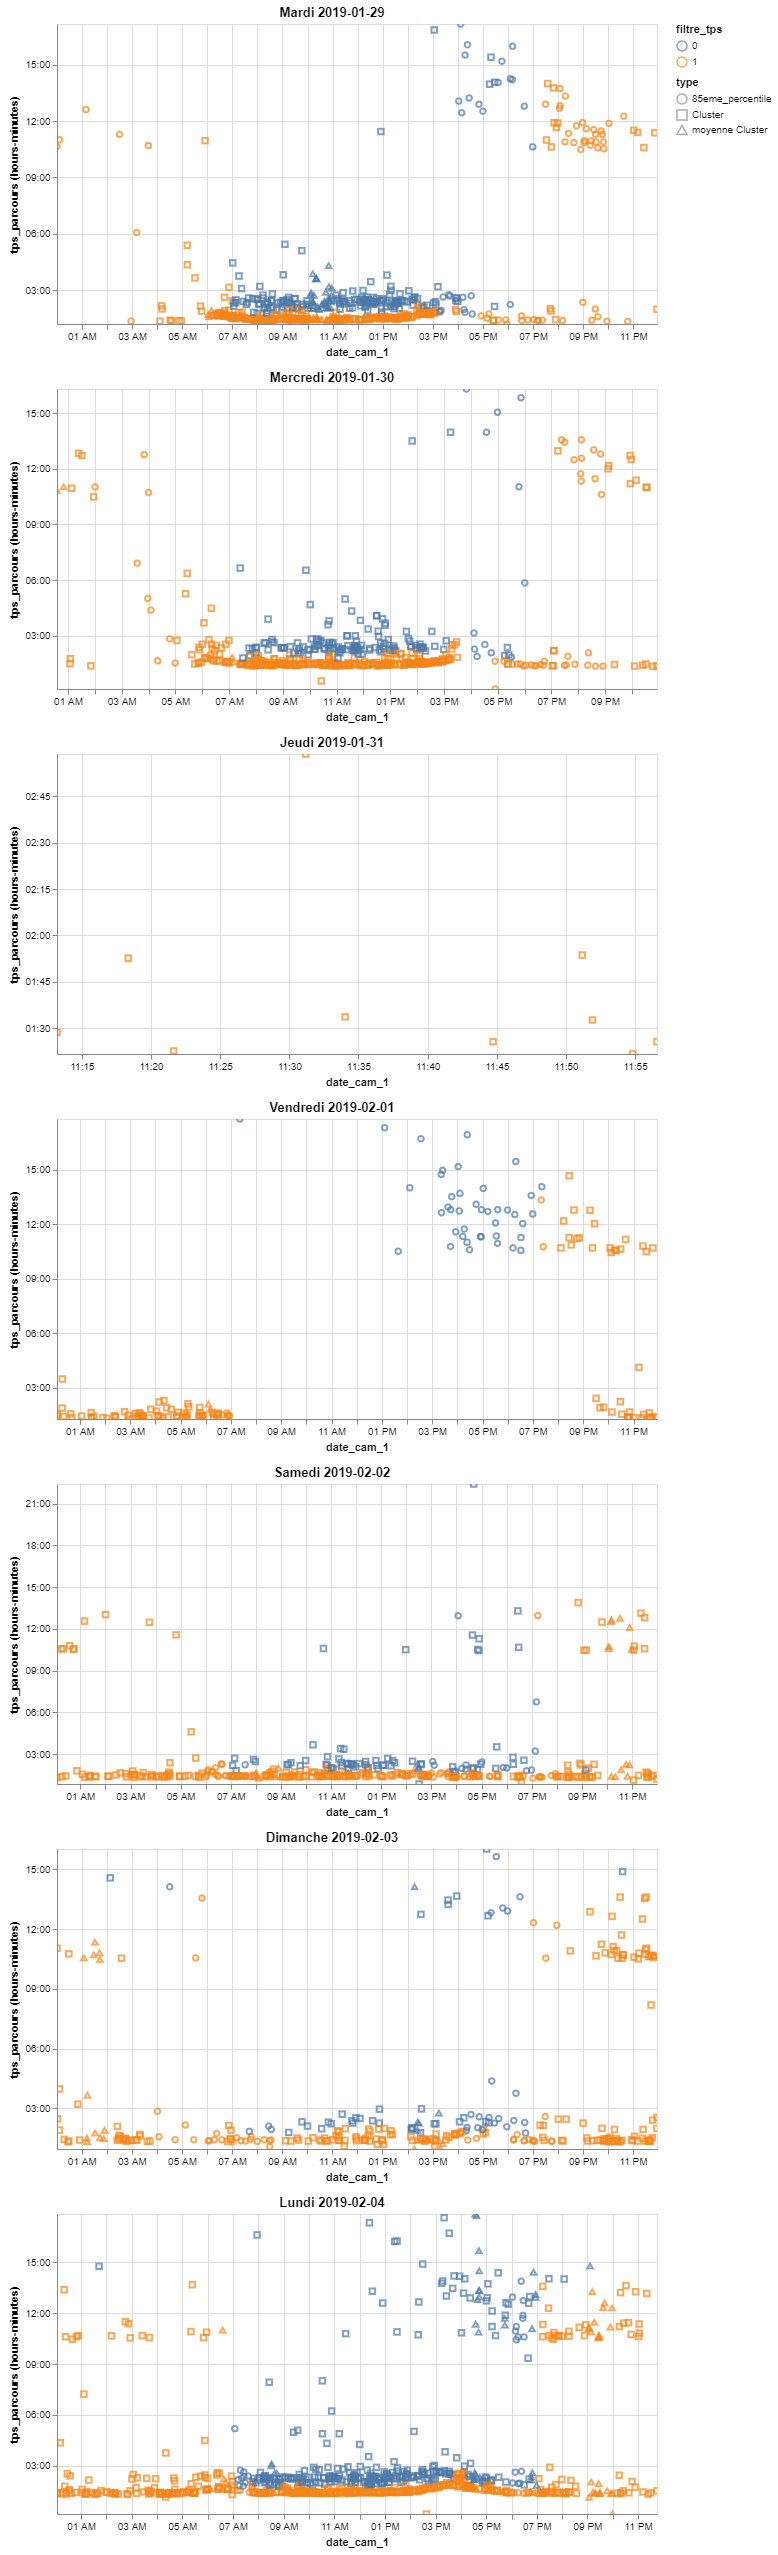

In [123]:
#exemple de visu sur 7 jours
t.graph_transit_filtre_multiple(df_transit_avec_filtre, 
                                '2019-01-29 00:00:00', '2019-01-29 23:59:59', 'A63-A10', 7)

In [140]:
#filtrer le df : 
dico_od_final=df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]

### 2.2.3. Correction des trajets depuis ou vers A660 relatifs à A63
> Il s'agit de corriger les trajets référencé depouis ou vers A660, alors que le vehicules a du passer sur A63 aussi.<br> plusieurs cas : 
- Passer sur A660 et vu avant ou apres sur A63
- Passer que sur A660 dans le sens nord sud puis sud-Nord, avec une immat déja vudans les plaques de transit et plus de 1jours d'ecart entre les passages

In [140]:
%time df_od_corrige=t.correction_trajet(df_3semaines, dico_od)

Wall time: 9min 58s


In [ ]:
#pour retrouver les trajets corrigé : 
dic_od_corrige.loc[dic_od_corrige['correction_o_d']==True]

### 2.2.3. extrapolation des trajets non complets
> pour les véhicules qui ont déja été identifié comme faisant du transit

CREER LE TABLEAU DE MATRICE O-D

In [10]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od,values='l', index='origine', columns='destination',aggfunc='count', margins=True )

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NaN,7565.0,7320.0,4299.0,658.0,NaN,19842
A62,2988.0,NaN,537.0,1381.0,1304.0,3222.0,9432
A63,7015.0,349.0,NaN,NaN,1712.0,32065.0,41141
A660,3052.0,1558.0,NaN,NaN,2270.0,7867.0,14747
A89,631.0,1672.0,2253.0,2616.0,NaN,1832.0,9004
N10,NaN,4470.0,27132.0,7558.0,1275.0,NaN,40435
All,13686.0,15614.0,37242.0,15854.0,7219.0,44986.0,134601


POURCENTAGE PL PAR PLAGE HORAIRE ET CAMERA

In [432]:
#isoler pl source
groupe_tv_type_simple=df_journee.groupby('immat')['l'].apply(lambda x:test_unicite_type(list(x),mode='1/2')).reset_index().drop_duplicates('immat')
df_pl=df_journee.join(groupe_tv_type_simple.loc[groupe_tv_type_simple['l']==1].set_index('immat'),on='immat',how='inner',rsuffix='_right')
df_pl.set_index('created',inplace=True)

#obtenir les nb de pl par heure et par camera sur la source
df_synthese_pl_tot=df_pl.groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_tot'})
df_synthese_pl_transit=dico_passag.set_index('created').groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_transit'})
df_pct_pl_transit=pd.concat([df_synthese_pl_tot,df_synthese_pl_transit], axis=1, join='inner')
df_pct_pl_transit.columns=[['nb_pl_tot','nb_pl_transit']]
df_pct_pl_transit['pct_pl_transit']=df_pct_pl_transit.apply(lambda x : float(x['nb_pl_transit'])*100 / x['nb_pl_tot'] ,axis=1)
df_pct_pl_transit

In [ ]:
pct_pl=t.pourcentage_pl_camera('2019-01-28 00:00:00', 1,df_3semaines.reset_index(),dico_passag)
pct_pl

VERIFICATION

In [126]:
#retrouver une immatriculatiob dans les données completes
df_3semaines.loc[df_3semaines['immat']=='96732ddb649df69af44d964e5d977407395072a2']

,camera_id,immat,fiability,l,state
created,,,,,
2019-02-01 09:04:36,15,96732ddb649df69af44d964e5d977407395072a2,89,1,
2019-02-01 10:42:07,4,96732ddb649df69af44d964e5d977407395072a2,79,0,


In [139]:

toto=df_3semaines.loc[pd.to_datetime('2019-02-01 09:00:00'):pd.to_datetime('2019-02-04 22:00:00')]
toto.loc[toto['camera_id']==11]

,camera_id,immat,fiability,l,state
created,,,,,
2019-02-01 23:00:51,11,a1a9148b72647a6aeb97219e0ece325b04a18c18,99,0,FR
2019-02-01 23:01:35,11,0a6309f51c40e3dba00b441dbb8c1a5a784e4c6a,99,0,FR
2019-02-01 23:01:47,11,bd9b1bc1bd72453a41baae0909a40aea0e009e4f,99,0,FR
2019-02-01 23:02:04,11,b2fe2ec5da89e6a74424375fdedd88ce4c83e87e,58,0,FR
2019-02-01 23:02:24,11,55dce112f48dc9811d985e9ed11b9d0ea7caf442,59,0,FR
2019-02-01 23:02:37,11,d9498bd1085e16e8e534abbc47f2ff78bacfdffe,99,0,FR
2019-02-01 23:04:15,11,9f45540c24b3534beb0beeae7d597de5f63f67ac,99,0,FR
2019-02-01 23:04:55,11,a895e9993249b44e116002dad11030555b53b657,99,0,ES
2019-02-01 23:05:28,11,6424572aa102be183ac14bcbcd1ded817fc1a79d,99,0,FR


In [54]:
# retrouver une immatriculatiob dans ledico o_d
dico_od.loc[dico_od['immat']=='b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period
18,2019-01-29 07:44:45,b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0,ES,1,2019-01-29 09:10:44,"(6, 18, 13)",N10,A63,N10-A63,01:25:59,2019-01-29 07:30


In [130]:
#verif a un horaire donne sur un trajet direct ou indirect ou global
#%time trajet_test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19],modeRegroupement='aucun')
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-02-01 00:00:00':'2019-02-02 23:59:59'], '2019-02-01 09:00:00', 60, [15, 11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')
test.df_transit.loc[test.df_transit['o_d']=='A63-A10']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours


TESTS A LA MANO

In [240]:
#pour trouver un trajet direct (sans disticntion de type ou autre)
test2=t.trouver_passages_consecutif(df_3semaines, '2019-01-29 00:00:00', '2019-01-29 23:59:59', 15, 19)
#test2=test2.set_index('created_y').sort_index()

In [286]:
%%time
#pour test des fonctions de trajets global

def filtrer_passage(liste, df_liste_trajet,cam) :
    """
    Récuperer les cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste[:len(liste_cams)]
    else : return liste

def recuperer_date_cam2(liste,liste_created,df_liste_trajet,cam):
    """
    Récuperer les horaires de passage des cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste_created[len(liste_cams)-1]
    else : return liste_created[-1]
    
def test_unicite_type(liste_l, mode='unique'):
    """test pour voir si un vehicule a ete toujours vu de la mme façon ou non
       en entre : liste de valeur de l (qui traduit si c'est u pl ou non) iisues d'une df
       en sortie : integer 0  ou 1 ou -1
       """ 
    if mode=='unique' : 
        if len(set(liste_l))==1 :
            return liste_l[0]
        else : 
            return -1
    elif mode=='1/2' :
        if any(liste_l)==1 : 
            return 1
        else : 
            return -1

camera1, camera2=15,5
df=df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'].copy()
df_duree=df.loc['2019-01-29 00:00:00':'2019-01-29 23:59:59']
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==camera1]
df_duree_autres_cam=df.loc[(df.loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
groupe=(df_duree_autres_cam.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 'l': lambda x : test_unicite_type(list(x),'1/2'),
                                                                               'created':lambda x: tuple(x)}))
groupe_pl=groupe.loc[groupe['l']==1].copy()
groupe_pl['camera_id']=groupe_pl.apply(lambda x : filtrer_passage(x['camera_id'],liste_complete_trajet,camera1),axis=1)#on filtre les cameras selon la liste des trajets existants
groupe_pl['created']=groupe_pl.apply(lambda x : recuperer_date_cam2(x['camera_id'],x['created'],liste_complete_trajet,camera1),axis=1)
df_ts_trajets=(groupe_pl.reset_index().merge(liste_complete_trajet[['cameras','origine','destination']],right_on='cameras', left_on='camera_id').
               rename(columns={'created':'date_cam_2'}).drop('camera_id',axis=1))
df_ts_trajets['o_d']=df_ts_trajets.apply(lambda x : x['origine']+'-'+x['destination'],axis=1)
df_agrege=df_duree_cam1.reset_index().merge(df_ts_trajets,on='immat').drop(['camera_id', 'l_x','state','fiability'],axis=1).rename(columns={'l_y':'l','created':'date_cam_1'})
df_agrege['tps_parcours']=df_agrege.apply(lambda x : x.date_cam_2-x.date_cam_1, axis=1)
df_agrege=df_agrege.loc[df_agrege['date_cam_2'] > df_agrege['date_cam_1']]

df_joint_passag_transit=df_agrege.merge(df_duree_autres_cam.reset_index(), on='immat')
df_passag_transit1=df_joint_passag_transit.loc[(df_joint_passag_transit.apply(lambda x : x['camera_id'] in x['cameras'], axis=1))]
df_passag_transit=(df_passag_transit1.loc[df_passag_transit1.apply(lambda x : x['date_cam_1']<=x['created']<=x['date_cam_2'], axis=1)]
                [['created','camera_id','immat','fiability','l_y','state']].rename(columns={'l_y':'l'}))
df_passag_transit

nb clusters = 1
tps parcours max : 0 days 02:26:52, final : 0 days 02:26:52


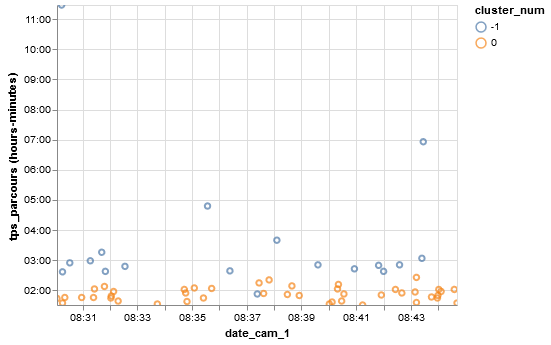

In [189]:
## pour tests des cluster
test=t.trajet(df_3semaines.loc['2019-01-31 00:00:00':'2019-02-01 23:59:59'], '2019-01-31 08:30:00', 15, [6, 13],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')
donnees=test.df_transit[test.df_transit['o_d']=='N10-A63'].copy()
donnees_src=donnees.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
liste_valeur=donnees_src.tps_parcours.apply(lambda x : ((pd.to_datetime('2018-01-29')+x)-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()#convertir les temps en integer
liste_date=donnees_src.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
if len(liste_valeur)<0 : #si il n'y a pas bcp de pl on arrete ; pourraitfair l'objet d'un parametre
    raise ClusterError()
#mise en forme des données pour passer dans sklearn 
matrice=np.array(liste_valeur).reshape(-1, 1)
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=1000, min_samples=len(liste_valeur)/4).fit(liste)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"nb clusters = {n_clusters_}")
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,donnees_src, left_on='index_base', right_index=True )
temp_parcours_max=results.loc[results.loc[:,'cluster_num']!=-1].groupby(['cluster_num'])['tps_parcours'].max().min()
temp_parcours_max2=temp_parcours_max
copie_df=results.copy()
copie_df.tps_parcours=pd.to_datetime('2018-01-29')+copie_df.tps_parcours
graph_tps_parcours = alt.Chart(copie_df).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)', color='cluster_num:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()
print(f'tps parcours max : {temp_parcours_max}, final : {temp_parcours_max2}')
graph_tps_parcours

TESTS

In [122]:
a660_n10=dico_od.loc[dico_od['o_d']=='N10-A63'].copy()
a660_n10=a660_n10[a660_n10.apply(lambda x : x['date_cam_1'].to_period('D')==pd.Period('2019-01-29',freq='D'), axis=1)].reset_index().drop('index', axis=1)
a660_n10.tps_parcours=pd.to_datetime('2018-01-28')+a660_n10.tps_parcours

In [47]:
dico_od_graph=dico_od.copy()
dico_od_graph.tps_parcours=pd.to_datetime('2019-01-29')+dico_od_graph.tps_parcours

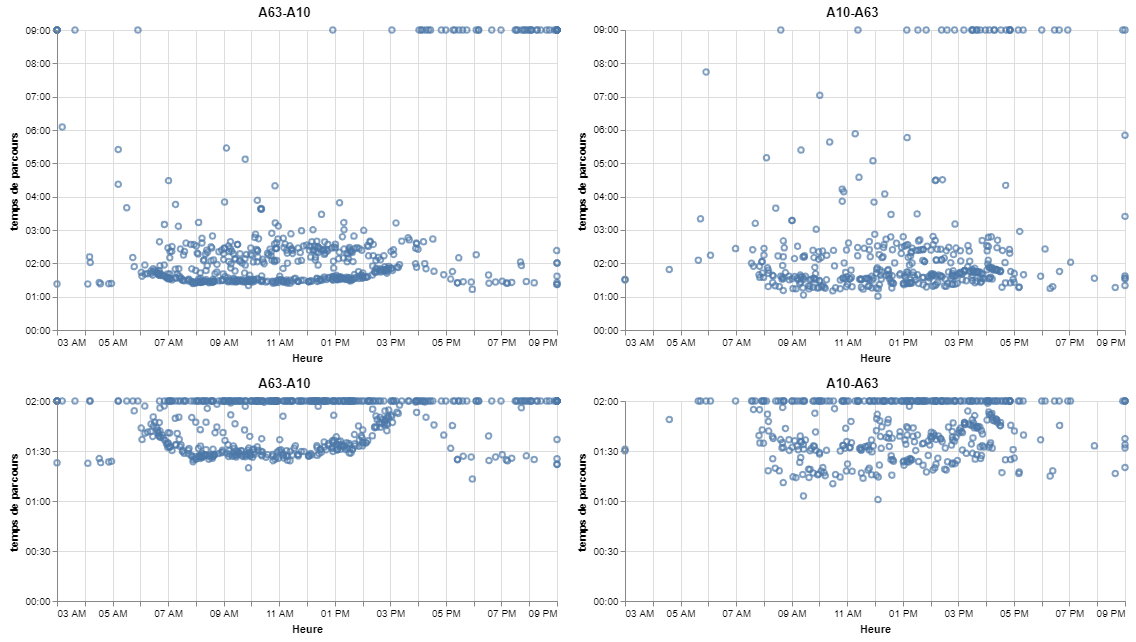

In [71]:
base_a63_n10 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A10-A63'], title='A10-A63').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
a63_n10=alt.vconcat(up_a63_n10,low_a63_n10)

base_n10_a63 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A63-A10'], title='A63-A10').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
n10_a63=alt.vconcat(up_n10_a63,low_n10_a63)
n10_a63|a63_n10

In [193]:
param_cluster=pd.DataFrame({'trajet':[('A10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A10-A63','N10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                        ('N10-A63')
                       ],
              'temps_etudie':[15,60,15,60,15],
              'delai':[600,1200,800,1000,1000],
              'nb_pt_min':[4,4,3,4,4]
             })
param_cluster.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [55]:
param_cluster=pd.read_json(r'E:\Boulot\lapi\param_cluster.json', orient='index')
param_cluster

,delai,nb_pt_min,temps_etudie,trajet
0,600,4,15,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
1,1200,4,60,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
2,800,3,15,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
3,1000,4,60,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"


In [278]:
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 10:00:00', 60, [15,11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')

In [279]:
test.temps_parcours_max

,date,temps,type,o_d
0,2019-01-29 10:00:00,01:22:38,Cluster,A63-N10
1,2019-01-29 10:00:00,02:49:06,85eme_percentile,A63-A10
2,2019-01-29 10:00:00,01:11:32,Cluster,A63-A89
3,2019-01-29 10:00:00,00:53:18,Cluster,A63-A62


In [121]:
pd.to_datetime('2019-01-28 00:00:00').strftime('%Y-%m-%d')

'2019-01-28'

In [72]:
tata

4